In [118]:
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
import importlib


from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import pickle

# import seaborn as sns 
# import matplotlib.pyplot as plt

In [119]:
def nfoldcv_scf(gxc_hvftrs_sub_g0, gxc_hvftrs_sub_g1, resolutions, k, 
                metas_sub, mods_selected, features_selected, settings,   
                ps, drop_npcs,
                cross_mod_distance_measure, knn, relaxation, n_cca,
                npc,
                output_pcX_all, output_cells_all, output_clst_and_umap,
                reduce_dim=0,
                nfolds=5, n_repeats=10):
    """
    """
    from sklearn.model_selection import KFold
    
    if os.path.isfile(output_clst_and_umap):
        df_clsts = pd.read_csv(output_clst_and_umap, sep="\t", index_col=0)
        
    else:
        # cluster on g0 with different resolutions
        pcX_all, cells_all = SCF_utils.core_scf_routine(mods_selected, features_selected, settings, 
                                                        metas_sub, gxc_hvftrs_sub_g0, 
                                                        ps, drop_npcs,
                                                        cross_mod_distance_measure, knn, relaxation, n_cca,
                                                        npc,
                                                        output_pcX_all, output_cells_all,
                                                        )
        df_clsts = SCF_utils.clustering_umap_routine(pcX_all, cells_all, mods_selected, metas_sub,
                                                     resolutions, k, 
                                                     umap_neighbors, min_dist, # doesn't matter
                                                     output_clst_and_umap,
                                                     cluster_only=True,
                                                     )
    
    # train and predict on g1
    res_nclsts = []
    res_mse_mean = {mod: [] for mod in mods_selected} 
    res_mse_se = {mod: [] for mod in mods_selected} 
    res_mse_t_mean = {mod: [] for mod in mods_selected} 
    res_mse_t_se = {mod: [] for mod in mods_selected}
    kl = KFold(n_splits=nfolds)
    
    # test different resolution
    for resolution in resolutions:
        print(resolution, end='')
        res_mse = {}
        res_mse_t = {} 

        cluster_col = 'cluster_joint_r{}'.format(resolution)
        df_clst = df_clsts[[cluster_col]].rename(columns={cluster_col: 'cluster'})
        nclsts = len(df_clst['cluster'].unique())
        res_nclsts.append(nclsts) # record number of clusters
        cells_clst = df_clst['cluster'] # cell -> cluster label look up series
        
        # do it in every modality
        for mod in mods_selected:
            print(mod)
            # set up
            res_mse[mod] = []
            res_mse_t[mod] = []
            
            metadata = metas_sub[mod].copy()
            metadata['cluster_cv'] = df_clst.loc[metadata.index, 'cluster'] 
            gxc_hvftr = gxc_hvftrs_sub_g1[mod]
            
            if settings[mod].mod_category == 'mc':
                assert np.all(metadata.index.values == gxc_hvftr.columns.values)
                features_y = gxc_hvftr.T.values
                if reduce_dim:
                    U, s, Vt = fbpca.pca(features_y, k=reduce_dim)
                    features_y = U.dot(np.diag(s))
            else:
                assert np.all(metadata.index.values == gxc_hvftr.cell)
                features_y = pd.DataFrame(gxc_hvftr.data.T.todense(), 
                                          index=gxc_hvftr.cell, 
                                          columns=gxc_hvftr.gene).values
                if reduce_dim:
                    U, s, Vt = fbpca.pca(features_y, k=reduce_dim)
                    features_y = U.dot(np.diag(s))
                
            ncells = len(metadata)
            
            for i_repeat in range(n_repeats):
                print('.', end='')
                
                # shuffle data
                cells_shuffled_idx = np.random.permutation(np.arange(ncells))
                metadata = metadata.iloc[cells_shuffled_idx, :] 
                metadata['cell_idx'] = np.arange(ncells)
                features_y = features_y[cells_shuffled_idx, :]
                
                # split training and test 
                for train_idx, test_idx in kl.split(np.arange(ncells)):
                    # compute cluster centroids for training cells 
                    y_centroids = {}
                    clsts_in_train = []
                    for clst, df_sub in metadata.iloc[train_idx].groupby('cluster_cv'):
                        cells_sub_idx = df_sub['cell_idx'].values
                        y_centroids[clst] = features_y[cells_sub_idx, :].mean(axis=0)
                        clsts_in_train.append(clst)
                        
                    # compute MSE for test cells
                    mse = 0
                    num_mse = 0
                    for j in test_idx: 
                        # cell idx j and cluster idx i
                        cell_j = metadata.index.values[j]
                        clst_i = cells_clst[cell_j]
                        if clst_i in clsts_in_train:
                            diff = features_y[j, :] - y_centroids[clst_i]
                            mse += diff.dot(diff)
                            num_mse += 1
                    mse /= num_mse
                    res_mse[mod].append(mse)

                    # compute MSE for training cells 
                    mse = 0
                    num_mse = 0
                    for j in train_idx: 
                        # cell idx j and cluster idx i
                        cell_j = metadata.index.values[j]
                        clst_i = cells_clst[cell_j]
                        diff = features_y[j, :] - y_centroids[clst_i]
                        mse += diff.dot(diff)
                        num_mse += 1
                    mse /= num_mse 
                    res_mse_t[mod].append(mse)
                # end of n-fold training test for 
                # each collect 1 data point
                
            # end of n-repeats for
            # summarize n-repeats into stats
            res_mse[mod] = np.array(res_mse[mod])
            
            res_mse_mean[mod].append(res_mse[mod].mean())
            res_mse_se[mod].append(1.96*res_mse[mod].std()/np.sqrt(nfolds))

            res_mse_t[mod] = np.array(res_mse_t[mod])
            res_mse_t_mean[mod].append(res_mse_t[mod].mean())
            res_mse_t_se[mod].append(1.96*res_mse_t[mod].std()/np.sqrt(nfolds))
            print('')
        # end of n-modality for 
        
    # end of resolution for
    res_nclsts = np.array(res_nclsts)
    
    for mod in mods_selected:
        res_mse_mean[mod] = np.array(res_mse_mean[mod])
        res_mse_se[mod] = np.array(res_mse_se[mod])
        res_mse_t_mean[mod] = np.array(res_mse_t_mean[mod])
        res_mse_t_se[mod] = np.array(res_mse_t_se[mod])

    return ( 
         res_nclsts,
         res_mse_mean, res_mse_se, 
         res_mse_t_mean, res_mse_t_se,
        )
    

In [183]:
def nfoldcv_scf(gxc_hvftrs_sub_g0, gxc_hvftrs_sub_g1, resolutions, k, 
                metas_sub, mods_selected, features_selected, settings,   
                ps, drop_npcs,
                cross_mod_distance_measure, knn, relaxation, n_cca,
                npc,
                output_pcX_all, output_cells_all, output_clst_and_umap,
                reduce_dim=0,
                nfolds=5, n_repeats=10):
    """
    """
    from sklearn.model_selection import KFold
    
#     if os.path.isfile(output_clst_and_umap):
#         df_clsts = pd.read_csv(output_clst_and_umap, sep="\t", index_col=0)
        
#     else:
    # cluster on g0 with different resolutions
    pcX_all, cells_all = SCF_utils.core_scf_routine(mods_selected, features_selected, settings, 
                                                    metas_sub, gxc_hvftrs_sub_g0, 
                                                    ps, drop_npcs,
                                                    cross_mod_distance_measure, knn, relaxation, n_cca,
                                                    npc,
                                                    output_pcX_all, output_cells_all,
                                                    )
    df_clsts = SCF_utils.clustering_umap_routine(pcX_all, cells_all, mods_selected, metas_sub,
                                                 resolutions, k, 
                                                 umap_neighbors, min_dist, # doesn't matter
                                                 output_clst_and_umap,
                                                 cluster_only=True,
                                                 )
    
    # train and predict on g1
    res_nclsts = []
    res_mse_mean = {mod: [] for mod in mods_selected} 
    res_mse_se = {mod: [] for mod in mods_selected} 
    res_mse_t_mean = {mod: [] for mod in mods_selected} 
    res_mse_t_se = {mod: [] for mod in mods_selected}
    kl = KFold(n_splits=nfolds)
    
    # test different resolution
    for resolution in resolutions:
        print(resolution, end='')
        res_mse = {}
        res_mse_t = {} 

        cluster_col = 'cluster_joint_r{}'.format(resolution)
        df_clst = df_clsts[[cluster_col]].rename(columns={cluster_col: 'cluster'})
        nclsts = len(df_clst['cluster'].unique())
        res_nclsts.append(nclsts) # record number of clusters
        cells_clst = df_clst['cluster'] # cell -> cluster label look up series
        
        # do it in every modality
        for mod in mods_selected:
            print(mod)
            # set up
            res_mse[mod] = []
            res_mse_t[mod] = []
            
            metadata = metas_sub[mod].copy()
            metadata['cluster_cv'] = df_clst.loc[metadata.index, 'cluster'] 
            gxc_hvftr = gxc_hvftrs_sub_g1[mod]
            
            if settings[mod].mod_category == 'mc':
                assert np.all(metadata.index.values == gxc_hvftr.columns.values)
                features_y = gxc_hvftr.T.values
                if reduce_dim:
                    U, s, Vt = fbpca.pca(features_y, k=reduce_dim)
                    features_y = U.dot(np.diag(s))
            else:
                assert np.all(metadata.index.values == gxc_hvftr.cell)
                features_y = pd.DataFrame(gxc_hvftr.data.T.todense(), 
                                          index=gxc_hvftr.cell, 
                                          columns=gxc_hvftr.gene).values
                if reduce_dim:
                    U, s, Vt = fbpca.pca(features_y, k=reduce_dim)
                    features_y = U.dot(np.diag(s))
                
            ncells = len(metadata)
            
            for i_repeat in range(n_repeats):
                print('.', end='')
                # shuffle data
                cells_shuffled_idx = np.random.permutation(np.arange(ncells))
                metadata = metadata.iloc[cells_shuffled_idx, :] 
                metadata['cell_idx'] = np.arange(ncells)
                features_y = features_y[cells_shuffled_idx, :]
                
                # split training and test 
                for train_idx, test_idx in kl.split(np.arange(ncells)):
                    ti = time.time()
#                     print(0, time.time()-ti)
                    # compute cluster centroids for training cells 
                    metadata_train = metadata.iloc[train_idx]
                    clsts_in_train = np.unique(metadata_train['cluster_cv'].values)
                    clsts_not_in_train = np.unique(metadata['cluster_cv'].values).tolist()
                    y_centroids = np.zeros((len(clsts_in_train), features_y.shape[1]))
                    cluster_to_idx_lookup = {}
                    for count_idx, (clst, df_sub) in enumerate(metadata_train.groupby('cluster_cv')):
                        cells_sub_idx = df_sub['cell_idx'].values
                        y_centroids[count_idx, :] = features_y[cells_sub_idx, :].mean(axis=0)
                        cluster_to_idx_lookup[clst] = count_idx
                        clsts_not_in_train.remove(clst)
                    for clst in clsts_not_in_train:
                        cluster_to_idx_lookup[clst] = -1
                    
                    # compute MSE for test cells
                    cells_j = metadata.index.values[test_idx]
                    clsts_i = cells_clst[cells_j]
                    clsts_i_idx = np.array([cluster_to_idx_lookup[clst] for clst in clsts_i])
                    cond = (clsts_i_idx != -1)  # test if clsts_i in clsts_in_train
                    test_idx, cells_j, clsts_i, clsts_i_idx = test_idx[cond], cells_j[cond], clsts_i[cond], clsts_i_idx[cond]
                    diff = features_y[test_idx, :] - y_centroids[clsts_i_idx, :]
                    mse = (diff**2).sum(axis=1).mean()
                    res_mse[mod].append(mse)
                    
                    # compute MSE for training cells 
                    cells_j = metadata.index.values[train_idx]
                    clsts_i = cells_clst[cells_j]
                    clsts_i_idx = np.array([cluster_to_idx_lookup[clst] for clst in clsts_i])
                    diff = features_y[train_idx, :] - y_centroids[clsts_i_idx, :]
                    mse = (diff*diff).sum(axis=1).mean()
                    res_mse_t[mod].append(mse)
                    
                # end of n-fold training test for 
                # each collect 1 data point
#                 break
                
            # end of n-repeats for
            # summarize n-repeats into stats
#             break
            res_mse[mod] = np.array(res_mse[mod])
            res_mse_mean[mod].append(res_mse[mod].mean())
            res_mse_se[mod].append(1.96*res_mse[mod].std()/np.sqrt(nfolds))

            res_mse_t[mod] = np.array(res_mse_t[mod])
            res_mse_t_mean[mod].append(res_mse_t[mod].mean())
            res_mse_t_se[mod].append(1.96*res_mse_t[mod].std()/np.sqrt(nfolds))
            print('')
#         break
        # end of n-modality for 
        
#     break
    # end of resolution for
    
    res_nclsts = np.array(res_nclsts)
    for mod in mods_selected:
        res_mse_mean[mod] = np.array(res_mse_mean[mod])
        res_mse_se[mod] = np.array(res_mse_se[mod])
        res_mse_t_mean[mod] = np.array(res_mse_t_mean[mod])
        res_mse_t_se[mod] = np.array(res_mse_t_se[mod])

    return ( 
         res_nclsts,
         res_mse_mean, res_mse_se, 
         res_mse_t_mean, res_mse_t_se,
        )
    

In [126]:
# plotting utils
def plot_errorbar_ax(ax, x, y, yerr, color='C0', label=''):
    """Plot a line with errorbar 
    """
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)
    
    ax.plot(x, y, '-o', 
           markersize=5,
           color=color,
           label=label,
           )
    ax.fill_between(x, y-yerr, y+yerr, 
                    color=color,
                    alpha=0.3,
                    zorder=0,
                   )
    return

def plot_errorbar_fancymin_ax(ax, x, y, yerr, color='C0', label=''):
    """Plot a line with errorbar + min position and min-se position
    """
    from scipy import optimize
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)

    plot_errorbar_ax(ax, x, y, yerr, color=color, label=label)
    
    # get minimum and plot
    min_arg = np.argmin(y)
    min_x = x[min_arg]
    min_y = y[min_arg]
    ax.plot(min_x, min_y, '^',
               markersize=12,
               color=color,
               )
    
    # get minimum + se and plot
    f = lambda _x: np.interp(_x, x[:min_arg], (y-yerr)[:min_arg]) - min_y
    try:
        res_root = optimize.root_scalar(f, bracket=(1, min_x))
        min_x_se = int(res_root.root+0.5)
    except: 
        min_x_se = x[0]
    ax.plot(min_x_se, min_y, 's', 
               markersize=10,
               color=color,
           )
        
    return int(min_x_se), int(min_x), min_y
    
def plot_bi_cv_ax(ax, x, y, yerr, color='C0', mod="", ylabel="MSE +/- SEM Normalized"):
    """
    """
    min_x_se, min_x, min_y = plot_errorbar_fancymin_ax(ax, x, y, yerr, color=color,)
    ax.set_title("{}: {} - {}".format(mod, min_x_se, min_x))
    ax.set_ylabel(ylabel)
    return

def plot_bi_cv_subfig(ax, x1, y1, yerr1, y1_tr, yerr1_tr, color1, mod1,
                    xlabel='Number of clusters',
                    ylabel='MSE +/- SEM Normalized',
                   ):
    from matplotlib.ticker import ScalarFormatter
    
    plot_errorbar_ax(ax, x1, y1_tr, yerr1_tr, color='black', label='Training error')
    plot_bi_cv_ax(ax, x1, y1, yerr1, color=color1, mod=mod1, ylabel=ylabel)
        
    ax.set_xscale('log', basex=2)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel(xlabel)
    
    return

# Configs  

In [200]:
name = 'mop_cv_test'
outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
output_results = outdir + '/cross_validation_results_{}.pkl'.format(name)
output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)

output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
# SAVE_KNN_MAT = True
# output_knn_mat = outdir + '/knn_{}_{{}}_from_{{}}.npz'.format(name)

In [201]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/organized_neurons_v6'

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [217]:
mods_selected = [
    'snmcseq_gene',
    'snatac_gene',
    'smarter_cells',
    'smarter_nuclei',
#     '10x_cells', 
#     '10x_nuclei', 
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     '10x_nuclei_v3_Macosko',
    ]

# features_selected = ['10x_cells']
features_selected = ['smarter_cells']
# check features
for features_modality in features_selected:
    assert (features_modality in mods_selected)

# within modality
ps = {'mc': 0.9,
      'atac': 0.1,
      'rna': 0.7,
     }
drop_npcs = {'mc': 0,
      'atac': 0,
      'rna': 0,
     }

# across modality
cross_mod_distance_measure = 'correlation' # cca
knn = 20 
relaxation = 3
n_cca = 30

# PCA
npc = 50

# clustering
k = 30
resolutions = [0.8, 1, 2, 4]
# umap
umap_neighbors = 60
min_dist=min_dist = 0.5

In [218]:
# f = '/cndd/fangming/CEMBA/data/MOp_all/results/intg_summary_mop_9mods_v2_cv_190709_v2.tsv'
# df_summary = pd.read_csv(f, sep='\t')
# print(df_summary.shape)
# df_summary.head()

In [219]:
# print(len(df_summary), len(df_summary['sample'].unique()))
# u, c = np.unique(df_summary['sample'].values, return_counts=True)
# dup = u[c > 1]
# print(len(dup))
# df_summary[df_summary['sample'].isin(dup)].sort_values('sample')

## Read in data 

In [220]:
log = snmcseq_utils.create_logger()
logging.info('*')

07/10/2019 09:28:38 PM *


In [221]:
# gene chrome lookup
chroms = np.arange(1, 20, 1).tolist() + ['X']
chroms = ['chr'+str(chrom) for chrom in chroms]

f = PATH_GENEBODY_ANNOTATION
df_genes = pd.read_csv(f, sep="\t")
gene_set_lookup = (df_genes[df_genes['chr'].isin(chroms)]
                             .groupby('gene_name').first()['chr']
                             .replace('chrX', 'chr20')
                             .apply(lambda x: int(x[3:])%2)
                    )
print(gene_set_lookup.value_counts())
gene_set_lookup.head()

1    27039
0    24632
Name: chr, dtype: int64


gene_name
0610005C13Rik    1
0610006L08Rik    1
0610009B22Rik    1
0610009E02Rik    0
0610009L18Rik    1
Name: chr, dtype: int64

In [222]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
#     try:
#         print(metas[mod].loc[dup])
#     except:
#         pass
    print(mod, metas[mod].shape)

snmcseq_gene (4936, 38)
snatac_gene (17370, 27)
smarter_cells (6244, 11)
smarter_nuclei (5911, 11)


In [223]:
gxc_hvftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        f_mat = hvftrs_f.format(mod, 'tsv')
        gxc_hvftrs[mod] = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
        gxc_hvftrs[mod].index = SCF_utils.standardize_gene_name(gxc_hvftrs[mod].index)  # standardize gene name 
        print(gxc_hvftrs[mod].shape, time.time()-ti)
        assert np.all(gxc_hvftrs[mod].columns.values == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
        continue
        
        
    f_mat = hvftrs_f.format(mod, 'npz')
    f_gene = hvftrs_gene.format(mod)
    f_cell = hvftrs_cell.format(mod)
    _gxc_tmp = snmcseq_utils.load_gc_matrix(f_gene, f_cell, f_mat)
    _gene = _gxc_tmp.gene
    _cell = _gxc_tmp.cell
    _mat = _gxc_tmp.data

    _gene = SCF_utils.standardize_gene_name(_gene)  # standardize gene name  
    
#     ## remove duplicated genes (for now)
#     u, c = np.unique(_gene, return_counts=True)
#     dup = u[c > 1]
#     uniq_bool = np.array([False if gene in dup else True for gene in _gene])
#     _gene_selected = _gene[uniq_bool]
#     _gene_selected_idx = np.arange(len(_gene))[uniq_bool]
#     _gene = _gene_selected
#     _mat = _mat.tocsr()[_gene_selected_idx, :]
#     ## remove duplicated genes complete
    
    gxc_hvftrs[mod] = GC_matrix(_gene, _cell, _mat)
    assert np.all(gxc_hvftrs[mod].cell == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
    print(gxc_hvftrs[mod].data.shape, time.time()-ti)
    

snmcseq_gene
(4830, 4936) 11.141098260879517
snatac_gene
(6827, 17370) 1.3105905055999756
smarter_cells
(4176, 6244) 1.096752643585205
smarter_nuclei
(3809, 5911) 0.5453863143920898


In [224]:
def subsampling(mods_selected, metas, gxc_hvftrs, p):
    """
    p - fraction of cells from each dataset to be included
    """
    metas_sub = collections.OrderedDict()
    gxc_hvftrs_sub = collections.OrderedDict()
    for mod in mods_selected: 
        # subsample meta
        cells_included = metas[mod].index.values[np.random.rand(len(metas[mod]))<p]
        metas_sub[mod] = metas[mod].loc[cells_included]

        # subsample gxc_hvftrs
        if settings[mod].mod_category == 'mc':
            gxc_hvftrs_sub[mod] = gxc_hvftrs[mod][cells_included]
            print(mod, metas_sub[mod].shape, gxc_hvftrs_sub[mod].shape, time.time()-ti)
            continue

        cells_included_idx = snmcseq_utils.get_index_from_array(gxc_hvftrs[mod].cell, cells_included)
        gxc_hvftrs_sub[mod] = GC_matrix(
                                        gxc_hvftrs[mod].gene,
                                        cells_included,
                                        gxc_hvftrs[mod].data.tocsc()[:, cells_included_idx],
                                        )
        print(mod, metas_sub[mod].shape, gxc_hvftrs_sub[mod].data.shape, time.time()-ti)
    return metas_sub, gxc_hvftrs_sub

In [225]:
# subsample cells
p = 1

if p < 1:
    metas_sub, gxc_hvftrs_sub = subsampling(mods_selected, metas, gxc_hvftrs, p)
else:
    metas_sub = metas
    gxc_hvftrs_sub = gxc_hvftrs

In [226]:
# split features metas_sub, gxc_hvftrs_sub_g0, gxc_hvftrs_sub_g1

gxc_hvftrs_sub_g0 = collections.OrderedDict()
gxc_hvftrs_sub_g1 = collections.OrderedDict()
for mod in mods_selected: 
    # split gxc_hvftrs
    if settings[mod].mod_category == 'mc':
        _genes = gxc_hvftrs_sub[mod].index.values
        _lookup = gene_set_lookup.reindex(_genes).fillna(-1).values
        _genes_set0 = _genes[_lookup == 0]
        _genes_set1 = _genes[_lookup == 1]
        print(len(_genes_set0), len(_genes_set1))
        gxc_hvftrs_sub_g0[mod] = gxc_hvftrs_sub[mod].loc[_genes_set0]
        gxc_hvftrs_sub_g1[mod] = gxc_hvftrs_sub[mod].loc[_genes_set1]
        
        print(mod, gxc_hvftrs_sub_g0[mod].shape, gxc_hvftrs_sub_g1[mod].shape, time.time()-ti)
        continue
        
    _genes = gxc_hvftrs_sub[mod].gene
    _lookup = gene_set_lookup.reindex(_genes).fillna(-1).values
    _genes_set0 = _genes[_lookup == 0]
    _genes_set0_index = snmcseq_utils.get_index_from_array(_genes, _genes_set0)
    _genes_set1 = _genes[_lookup == 1]
    _genes_set1_index = snmcseq_utils.get_index_from_array(_genes, _genes_set1)
    print(len(_genes_set0), len(_genes_set1))
    gxc_hvftrs_sub_g0[mod] = GC_matrix(
                                _genes_set0,
                                gxc_hvftrs_sub[mod].cell,
                                gxc_hvftrs_sub[mod].data.tocsr()[_genes_set0_index,:],
                                )
    gxc_hvftrs_sub_g1[mod] = GC_matrix(
                                _genes_set1,
                                gxc_hvftrs_sub[mod].cell,
                                gxc_hvftrs_sub[mod].data.tocsr()[_genes_set1_index,:],
                                )
    
    print(mod, gxc_hvftrs_sub_g0[mod].data.shape, gxc_hvftrs_sub_g1[mod].data.shape, time.time()-ti)


1782 2417
snmcseq_gene (1782, 4936) (2417, 4936) 1.2959001064300537
2810 3571
snatac_gene (2810, 17370) (3571, 17370) 1.6318068504333496
1684 1998
smarter_cells (1684, 6244) (1998, 6244) 1.8219952583312988
1525 1769
smarter_nuclei (1525, 5911) (1769, 5911) 1.853407382965088


In [227]:
ti = time.time()

resolutions = [0.5, 1, 2, 3, 4, 6, 8, 12, 16, 20]
(
 res_nclsts, 
 res_mse_mean, res_mse_se, 
 res_mse_t_mean, res_mse_t_se, 
) = nfoldcv_scf(
            gxc_hvftrs_sub_g1, gxc_hvftrs_sub_g0, resolutions, k, 
            metas_sub, mods_selected, features_selected, settings,   
            ps, drop_npcs,
            cross_mod_distance_measure, knn, relaxation, n_cca,
            npc,
            output_pcX_all, output_cells_all, output_clst_and_umap,
            reduce_dim=0,
            nfolds=5, n_repeats=10)

print(time.time() - ti)

07/10/2019 09:28:55 PM Smoothing within modalities...


Time used to build kNN map 0.15034079551696777
Time used to get kNN 0.19636321067810059


07/10/2019 09:28:57 PM snmcseq_gene: 1.4503023624420166


Time used to build kNN map 0.24587583541870117
Time used to get kNN 0.8019909858703613


07/10/2019 09:29:02 PM snatac_gene: 5.144747734069824


Time used to build kNN map 0.08267331123352051
Time used to get kNN 1.0215239524841309


07/10/2019 09:29:04 PM smarter_cells: 1.9238557815551758


Time used to build kNN map 0.08457303047180176
Time used to get kNN 0.2341289520263672


07/10/2019 09:29:05 PM smarter_nuclei: 0.9401891231536865
07/10/2019 09:29:05 PM Constructing a joint matrix...
07/10/2019 09:29:05 PM Imputing into smarter_cells space...
07/10/2019 09:29:05 PM for snmcseq_gene cells...
07/10/2019 09:29:14 PM for snatac_gene cells...
07/10/2019 09:29:36 PM for smarter_cells cells...
07/10/2019 09:29:36 PM for smarter_nuclei cells...
07/10/2019 09:29:49 PM Saved output to: /cndd/fangming/CEMBA/data/MOp_all/results/pcX_all_mop_cv_test.npy
07/10/2019 09:29:49 PM Saved output to: /cndd/fangming/CEMBA/data/MOp_all/results/cells_all_mop_cv_test.npy
07/10/2019 09:29:49 PM resolution r: 0.5
07/10/2019 09:29:54 PM resolution r: 1
07/10/2019 09:29:58 PM resolution r: 2
07/10/2019 09:30:03 PM resolution r: 3
07/10/2019 09:30:07 PM resolution r: 4
07/10/2019 09:30:12 PM resolution r: 6
07/10/2019 09:30:16 PM resolution r: 8
07/10/2019 09:30:21 PM resolution r: 12
07/10/2019 09:30:25 PM resolution r: 16
07/10/2019 09:30:29 PM resolution r: 20


0.5snmcseq_gene
..........
snatac_gene
..........
smarter_cells
..........
smarter_nuclei
..........
1snmcseq_gene
..........
snatac_gene
..........
smarter_cells
..........
smarter_nuclei
..........
2snmcseq_gene
..........
snatac_gene
..........
smarter_cells
..........
smarter_nuclei
..........
3snmcseq_gene
..........
snatac_gene
..........
smarter_cells
..........
smarter_nuclei
..........
4snmcseq_gene
..........
snatac_gene
..........
smarter_cells
..........
smarter_nuclei
..........
6snmcseq_gene
..........
snatac_gene
..........
smarter_cells
..........
smarter_nuclei
..........
8snmcseq_gene
..........
snatac_gene
..........
smarter_cells
..........
smarter_nuclei
..........
12snmcseq_gene
..........
snatac_gene
..........
smarter_cells
..........
smarter_nuclei
..........
16snmcseq_gene
..........
snatac_gene
..........
smarter_cells
..........
smarter_nuclei
..........
20snmcseq_gene
..........
snatac_gene
..........
smarter_cells
..........
smarter_nuclei
..........
606.5

In [228]:
# Saving the objects:
with open(output_results, 'wb') as f: 
    pickle.dump((
                 res_nclsts, 
                 res_mse_mean, res_mse_se, 
                 res_mse_t_mean, res_mse_t_se, 
                ), f)

In [229]:
# Getting back the objects:
with open(output_results, 'rb') as f: 
    (res_nclsts, 
     res_mse_mean, res_mse_se, 
     res_mse_t_mean, res_mse_t_se, 
    ) = pickle.load(f)

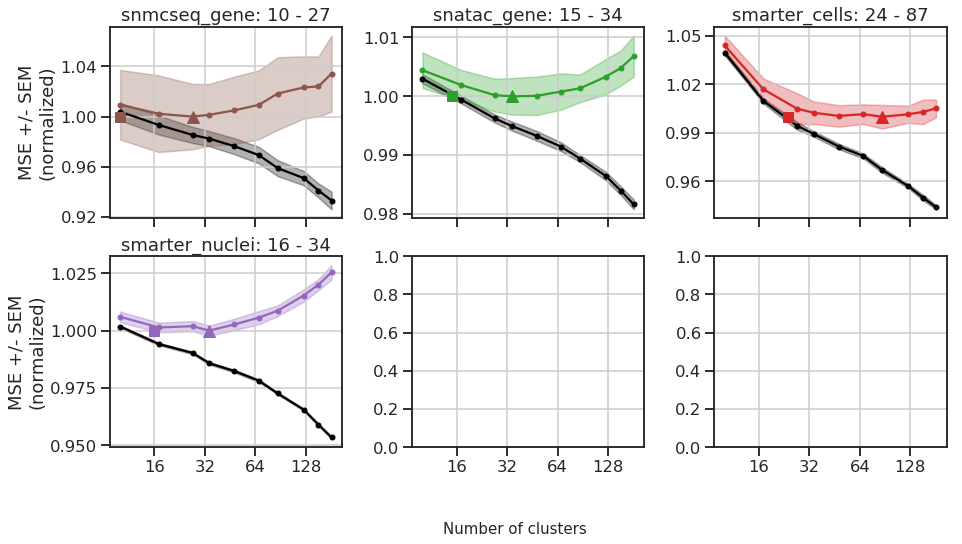

In [230]:
output = output_figures.format('cluster_cv_nosharey', 'pdf')
n = len(mods_selected)
nx = 3
ny = int((n+nx-1)/nx)
scale = 1
fig, axs = plt.subplots(ny, nx, figsize=(5*nx*scale,4*ny*scale), sharex=True, sharey=False)
axs = axs.flatten()
for i, (mod, ax) in enumerate(zip(mods_selected, axs)):
    base_level = np.min(res_mse_mean[mod])
    if i % nx == 0:
        ylabel = 'MSE +/- SEM\n(normalized)'
    else:
        ylabel = ''
    xlabel = ''
    plot_bi_cv_subfig(ax, res_nclsts, 
                      res_mse_mean[mod]/base_level, res_mse_se[mod]/base_level, 
                      res_mse_t_mean[mod]/base_level, res_mse_t_se[mod]/base_level, 
                      settings[mod].color, mod, 
                      xlabel=xlabel,
                      ylabel=ylabel
                     )
    ax.yaxis.set_major_locator(mtick.MaxNLocator(4))

fig.subplots_adjust(wspace=0.3, bottom=0.15)
fig.text(0.5, 0, 'Number of clusters', ha='center', fontsize=15)
fig.savefig(output, bbox_inches='tight')
plt.show()

In [231]:
# output = output_figures.format('cluster_cv_sharey', 'pdf')
# n = len(mods_selected)
# nx = 3
# ny = int((n+nx-1)/nx)
# scale = 1
# fig, axs = plt.subplots(ny, nx, figsize=(5*nx*scale,4*ny*scale), sharex=True, sharey=True)
# axs = axs.flatten()
# for i, (mod, ax) in enumerate(zip(mods_selected, axs)):
#     base_level = np.min(res_mse_mean[mod])
#     if i % nx == 0:
#         ylabel = 'MSE +/- SEM\n(normalized)'
#     else:
#         ylabel = ''
#     xlabel = ''
#     plot_bi_cv_subfig(ax, res_nclsts, 
#                       res_mse_mean[mod]/base_level, res_mse_se[mod]/base_level, 
#                       res_mse_t_mean[mod]/base_level, res_mse_t_se[mod]/base_level, 
#                       settings[mod].color, mod, 
#                       xlabel=xlabel,
#                       ylabel=ylabel
#                      )
#     ax.yaxis.set_major_locator(mtick.MaxNLocator(4))

# fig.subplots_adjust(wspace=0.1, bottom=0.15)
# fig.text(0.5, 0, 'Number of clusters', ha='center', fontsize=15)
# fig.savefig(output, bbox_inches='tight')
# plt.show()